# 1. Importing packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [2]:
path = '../data/'

# 2. Visualising data

In [3]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,cat,700
1,deer,600
2,dog,900
3,horse,600


<AxesSubplot:xlabel='Name of class', ylabel='Number of samples'>

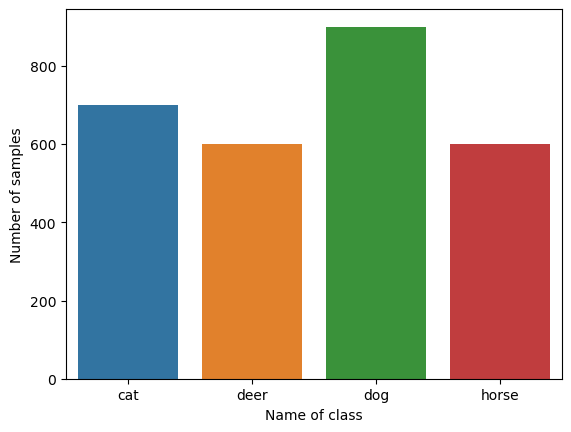

In [4]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

['cat', 'deer', 'dog', 'horse']


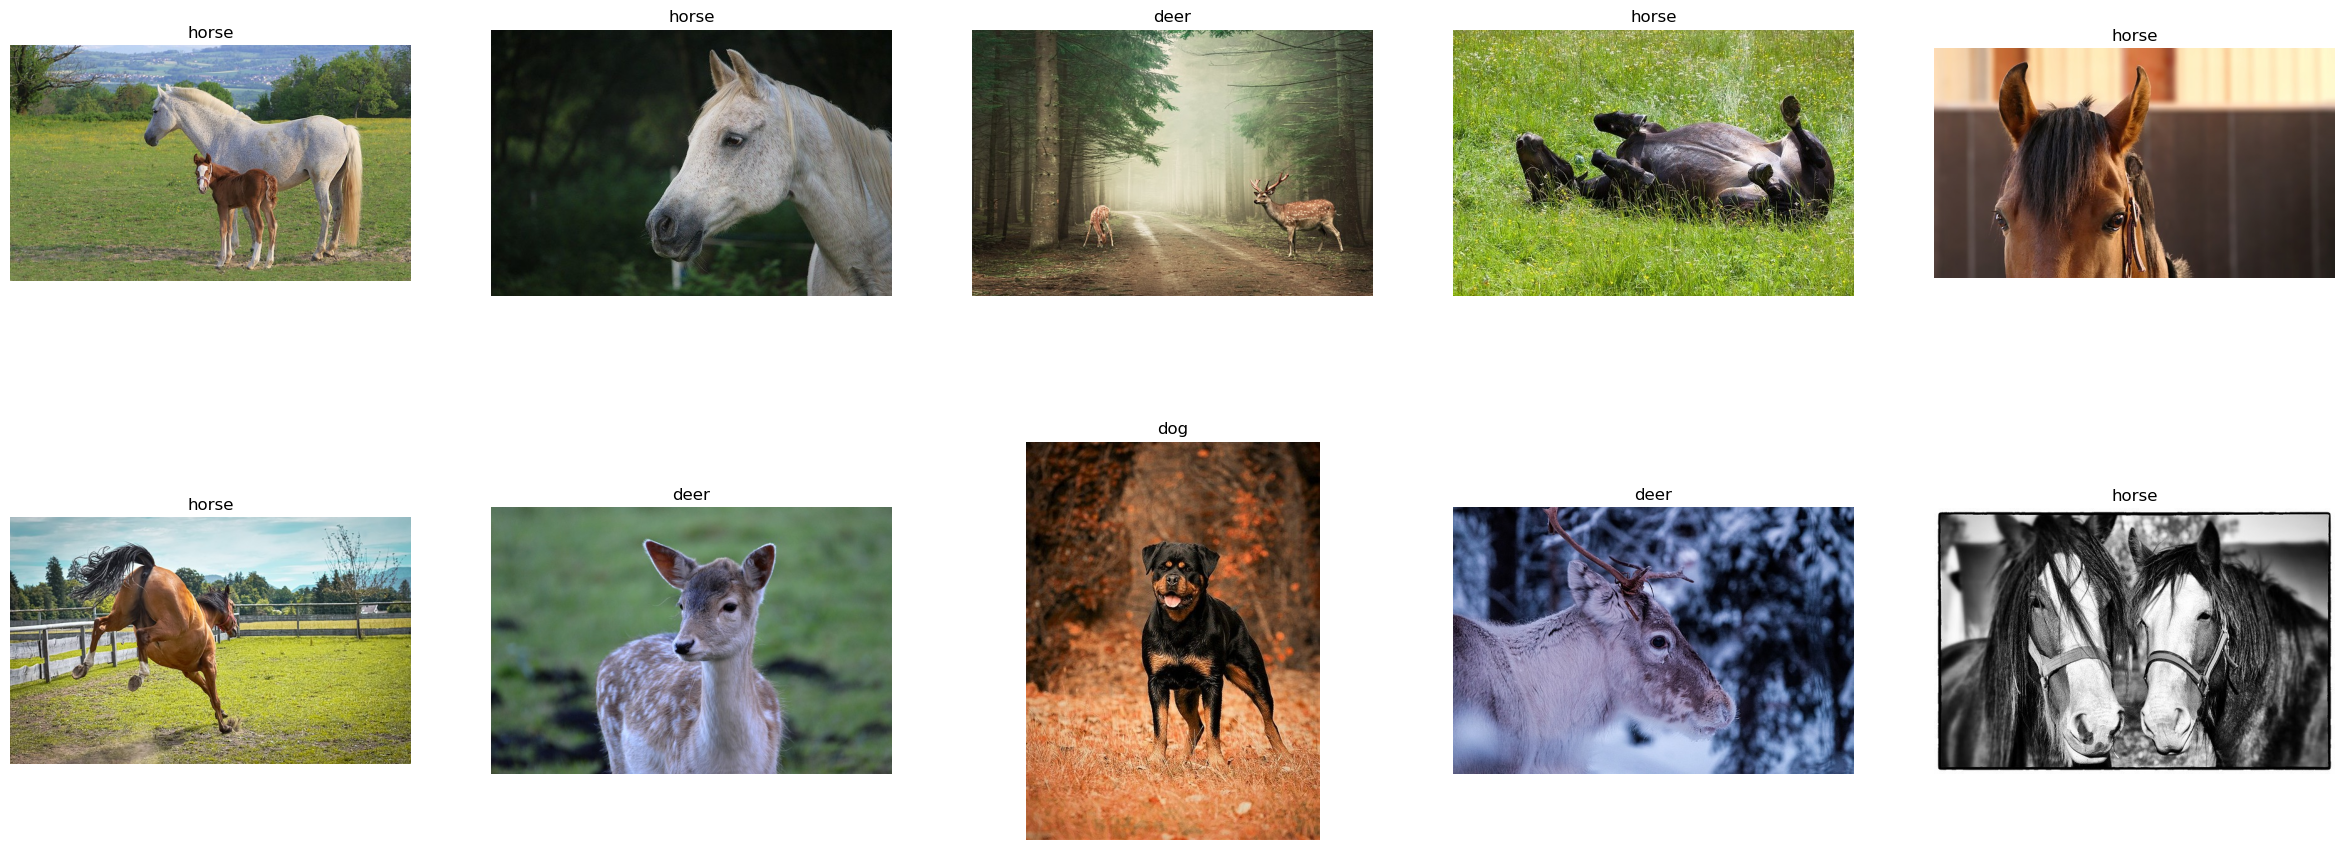

In [5]:
classes = os.listdir(path+'/train')
print(classes)

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[i])
    j = random.randint(0,600)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [6]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, validation_split=0.2)

In [7]:
train_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

Found 2240 images belonging to 4 classes.


In [8]:
val_ds = image_datagen.flow_from_directory(
        path+'/train',
        subset='validation',
        target_size=(224 , 224),
        batch_size=32 )

Found 560 images belonging to 4 classes.


# Modeling

### Load Pretrained Model

In [9]:
# base model
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224 , 224, 3),
    include_top=False,
    weights='imagenet'
)

# base_model.trainable = False
base_model.summary()
# feature_beach = base_model(train_ds)
base_model.trainable = False

: 

: 

In [ ]:
# using mobilenet

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation="softmax" , name="classification"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

# 5. Training and evaluating

In [ ]:
history = model.fit(train_ds , validation_data = val_ds , epochs = 3)

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
test_ds = image_datagen.flow_from_directory(
        path+'/test',
        subset='training',
        target_size=(224 , 224),
        batch_size=32)

In [ ]:
predict = model.predict(test_ds)

In [ ]:
predict = np.argmax(predict , axis = 1)

In [ ]:
labels = classes

predicted = [labels[k] for k in predict]

print(predicted[:5])

In [ ]:
from tensorflow.keras.preprocessing import image

random_index = np.random.randint(1, len(test_ds) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = image.load_img(path+'test/test/'+str(random_index[i])+'.jpg', target_size=(224, 224))
    ax.imshow(img)
    img = image.img_to_array(img)
    img_arr = np.expand_dims(img, 0)
    # img_arr = tf.keras.applications.mobilenet_v3.preprocess_input(img_arr)
    pred = model.predict(img_arr)
    
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (classes)
    # labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    ax.set_title(f"Predicted: {pred}", color='green')
plt.show()
plt.tight_layout()

In [ ]:
# accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(test_ds.classes, predict)


# 6. Preparing for submission

In [ ]:
sub_csv ='../input/4-animal-classification/Sample_submission.csv'
path_test = '../input/4-animal-classification/test/test'

In [ ]:
df_sub = pd.read_csv(sub_csv)
image_id = df_sub['ID']
df_sub.head(10)

In [ ]:
# each image will be treated individually and saved in a list which is then merged with the id of it's correspondence

from tensorflow.keras.preprocessing.image import load_img


# making a list for our predictions
labels = []


for i in image_id:
    image = load_img(path_test+'/'+str(i)+'.jpg', target_size=(224, 224))
    img = np.array(image)
    img = img / 255.0
    img = img.reshape(1,224,224,3)
    label = model.predict(img)
    label_id = label[0].tolist()
    
    labels.append(label_id.index(max(label_id)))


In [ ]:
# we will replace the previous empty columns with the new predictions    
    
df_sub['Label'] = labels
df_sub.head(10)

In [ ]:
# saving file
df_sub.to_csv('submission_file.csv',index=False)